# Problem set 2

A lot of the phenomena around us or relationships of any kind may be mapped to networks. Often graphs, the mathematical objects, help structural and functional analysis of these networks.

In this problem set we are interested in the citation network. Visit [aMiner](https://aminer.org/citation) for input data.

## Problem 2.1

Reconstruct the scitation graphs based on these data. Analize those graphs. Besides the usual graph metrics for the _whole_ graph try to see if you can say something about temporal evolution.
Define various strategies for node removal and see how the _whole_ graph degrades.
Discuss what you find.

## Problem 2.2 (optional)

Design and implement a crawler to download meta information about articles. You may choose to query [scholar](https://scholar.google.com/) or [arXiv](https://arxiv.org/). The former indexes scientific articles, the latter gives open access to more than a million of e-prints in various fields of science.

Try to collect properties like:
* date of submission
* the list of articles cited
* the list of authors
* the field of science
* the title of the artice

Reconstruct the citation graph and carry out analisys as in Problemset 2.1. Discuss your findings.

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx

# Downloading data

In [2]:
!/bin/bash -c 'if [[ ! -d data ]]; then mkdir data; fi'
!/bin/bash -c 'if [[ ! -f data/citation-network1.zip ]]; then curl http://aminer.org/lab-datasets/citation/citation-network1.zip -o ./data/citation-network1.zip; fi'

In [3]:
!/bin/bash -c 'if [[ ! -f data/outputacm.txt ]]; then cd data && unzip -o citation-network1.zip; fi'

In [4]:
!ls -lah data

total 484M
drwxrwxr-x 2 dnagy dnagy 4.0K Dec 11 22:39 .
drwxrwxr-x 8 dnagy dnagy 4.0K Dec 13 14:33 ..
-rw-rw-r-- 1 dnagy dnagy 127M Dec 11 22:39 citation-network1.zip
-rw-rw-r-- 1 dnagy dnagy 358M Apr 11  2010 outputacm.txt


In [5]:
"""
DATA FORMAT:
#* --- paperTitle
#@ --- Authors
#t ---- Year
#c  --- publication venue
#index 00---- index id of this paper
#% ---- the id of references of this paper (there are multiple lines, with each indicating a reference)
#! --- Abstract

The following is an example:

#*Information geometry of U-Boost and Bregman divergence
#@Noboru Murata,Takashi Takenouchi,Takafumi Kanamori,Shinto Eguchi
#t2004
#cNeural Computation
#index436405
#%94584
#%282290
#%605546
#%620759
#%564877
#%564235
#%594837
#%479177
#%586607
#!We aim at an extension of AdaBoost to U-Boost, in the paradigm to build a stronger classification machine from a set of weak learning machines. A geometric understanding of the Bregman divergence defined by a generic convex function U leads to the U-Boost method in the framework of information geometry extended to the space of the finite measures over a label set. We propose two versions of U-Boost learning algorithms by taking account of whether the domain is restricted to the space of probability functions. In the sequential step, we observe that the two adjacent and the initial classifiers are associated with a right triangle in the scale via the Bregman divergence, called the Pythagorean relation. This leads to a mild convergence property of the U-Boost algorithm as seen in the expectation-maximization algorithm. Statistical discussions for consistency and robustness elucidate the properties of the U-Boost methods based on a stochastic assumption for training data.
""";

In [6]:
TAG_TITLE='#*'
TAG_AUTHORS='#@'
TAG_YEAR='#t'
TAG_VENUE='#c'
TAG_IDX='#index'
TAG_REF='#%'
TAG_ABS='#!'

In [7]:
# Print first few lines from the downloaded data
datafile='./data/outputacm.txt'
lines = []
# 363
# 96
N=100000-3 # process 2497 lines
with open(datafile, "r") as f:
    for idx, line in enumerate(f):
        if idx<N:
            lines.append(line)
        else:
            break
print(''.join(lines[-10:]))

#c
#index15031

#*Rapid and brief communication: Face recognition based on 2D Fisherface approach
#@Xiao-Yuan Jing,Hau-San Wong,David Zhang
#t2006
#cPattern Recognition
#index15032
#%95021
#!Two-dimensional (2D) discrimination analysis using methods such as 2D PCA and Image LDA is of interest in face recognition because it extracts discriminative features faster than one-dimensional (1D) discrimination analysis. However, existing 2D methods generally use more discriminative features and take longer to test than 1D methods. 2D PCA in particular cannot make full use of the Fisher discriminant criterion. Image LDA also has drawbacks in that it cannot perform 2D principal component analysis and discards components with poor discriminative capabilities. In addition, existing 2D methods cannot provide an automatic strategy to choose 2D principal components or discriminant vectors. In this paper, we propose 2D Fisherface, a novel discrimination approach that combines the two-stage ''PCA+LDA''

In [8]:
"""
What we see:
- the first line contains the number of records
- the records are indexed from 0
- the records are separated by a newline
""";

In [9]:
N_records = int(lines.pop(0))
N_records

629814

In [10]:
sample=''.join(lines)
records=sample.split('\n\n')
print(len(records))
print(records[0])

15033
#*Automated Deduction in Geometry: 5th International Workshop, ADG 2004, Gainesville, FL, USA, September 16-18, 2004, Revised Papers (Lecture Notes in Computer ... / Lecture Notes in Artificial Intelligence)
#@Hoon Hong,Dongming Wang
#t2006
#c
#index0


In [11]:
class Node:
    def __init__(self, data):
        self.data = data
    def __hash__(self):
        return self.data[TAG_IDX]

def parse_record(r):
    rv = {
        TAG_TITLE: None,
        TAG_AUTHORS: None,
        TAG_YEAR: None,
        TAG_VENUE: None,
        TAG_IDX: None,
        TAG_REF: [],
        TAG_ABS: None
    }
    for k in r.split('\n'):
        if k.startswith(TAG_TITLE):
            rv[TAG_TITLE] = k.replace(TAG_TITLE, '')
        elif k.startswith(TAG_AUTHORS):
            rv[TAG_AUTHORS] = k.replace(TAG_AUTHORS, '')
        elif k.startswith(TAG_YEAR):
            rv[TAG_YEAR] = int(k.replace(TAG_YEAR, ''))
        elif k.startswith(TAG_VENUE):
            rv[TAG_VENUE] = k.replace(TAG_VENUE, '')
        elif k.startswith(TAG_IDX):
            rv[TAG_IDX] = int(k.replace(TAG_IDX, ''))
        elif k.startswith(TAG_REF):
            rv[TAG_REF].append(int(k.replace(TAG_REF, '')))
        elif k.startswith(TAG_ABS):
            rv[TAG_ABS] = k.replace(TAG_ABS, '')
        pass
    return Node(data=rv)

In [12]:
# parse all nodes
nodelist = [parse_record(r) for r in records]

In [13]:
# Add all records to a graph
G = nx.DiGraph()

# Store only those nodes that are referenced by or are refering to other nodes
useful_indices = []

for node in nodelist:
    G.add_node(node.data[TAG_IDX])
    if node.data[TAG_REF] != []:
        useful_indices.append(node.data[TAG_IDX])
        for ref in node.data[TAG_REF]:
            useful_indices.append(ref)
            G.add_node(ref)
            G.add_edge(node.data[TAG_IDX], ref)

In [14]:
# Relabel nodes
G = nx.relabel_nodes(G, lambda x: hash(x))

In [15]:
# Some style
NODE_COLOR='#c82aeb'
EDGE_COLOR='#238ce8'
FONT_COLOR='w'
DRAW_FULL_GRAPHS=False # It takes too much time to draw full graphs

In [16]:
if DRAW_FULL_GRAPHS:
    fig = plt.figure(figsize=(10,8), dpi=96)
    nx.draw(
        G,
        with_labels=True,
        node_color=NODE_COLOR,
        node_size=100,
        edge_color=EDGE_COLOR, 
        font_size=9,
        font_color=FONT_COLOR
    )
    fig.set_facecolor('k')

Text(0.5, 1.0, 'Out Degree Histogram')

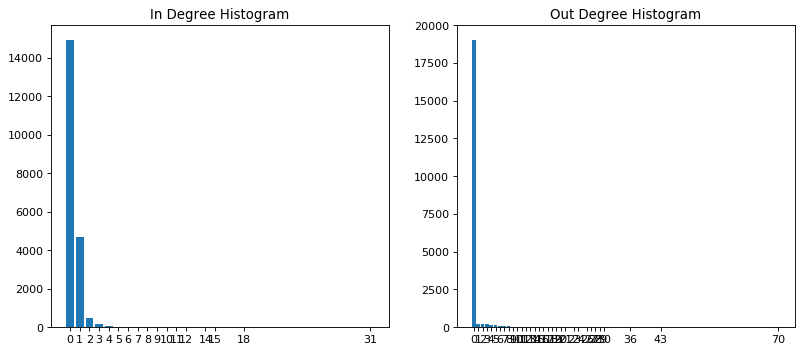

In [17]:
### Degree distributions
import collections
in_degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
out_degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)

inDegreeCount = collections.Counter(in_degree_sequence)
indeg, incnt = zip(*inDegreeCount.items())
indeg=np.array(indeg)

outDegreeCount = collections.Counter(out_degree_sequence)
outdeg, outcnt = zip(*outDegreeCount.items())
outdeg = np.array(outdeg)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=80)

axes[0].bar(indeg, incnt, width=0.80)
axes[0].set_xticks([d for d in indeg])
axes[0].set_xticklabels(indeg)
axes[0].set_title("In Degree Histogram")

axes[1].bar(outdeg, outcnt, width=0.80)
axes[1].set_xticks([d for d in outdeg])
axes[1].set_xticklabels(outdeg)
axes[1].set_title("Out Degree Histogram")

In [18]:
print("Averege in degrees:", np.mean(in_degree_sequence))
print("Max in degrees:", np.max(in_degree_sequence))
print("Averege out degrees:", np.mean(out_degree_sequence))
print("Max out degrees:", np.max(out_degree_sequence))

Averege in degrees: 0.3332843209331961
Max in degrees: 31
Averege out degrees: 0.3332843209331961
Max out degrees: 70


### Plot the 10 largest clusters

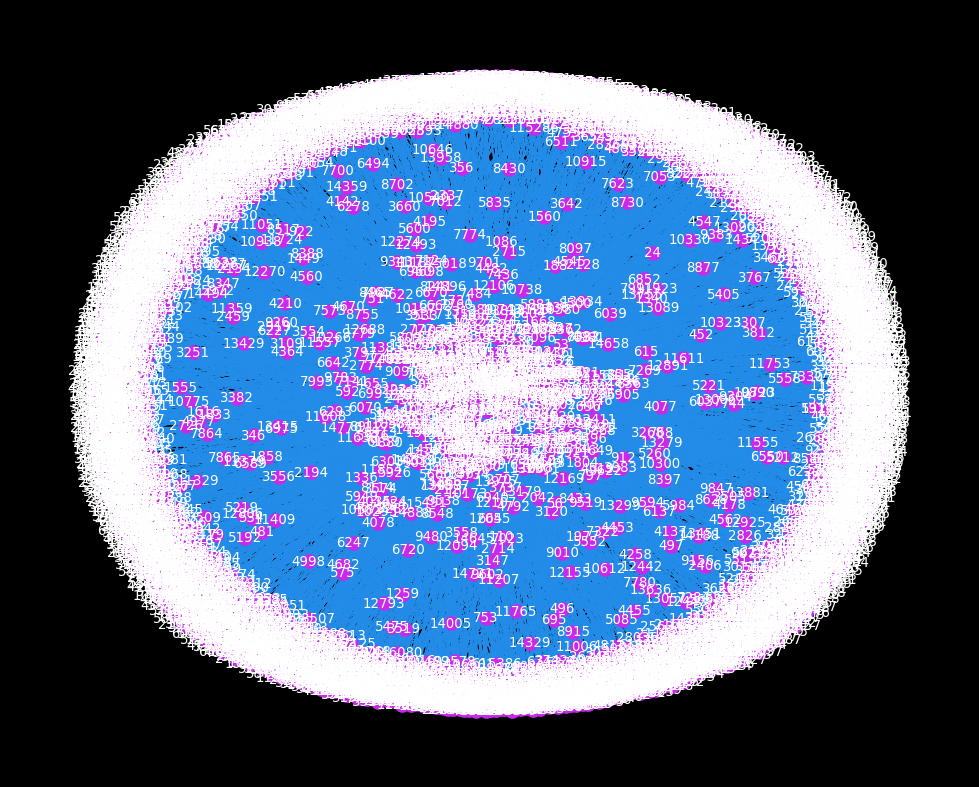

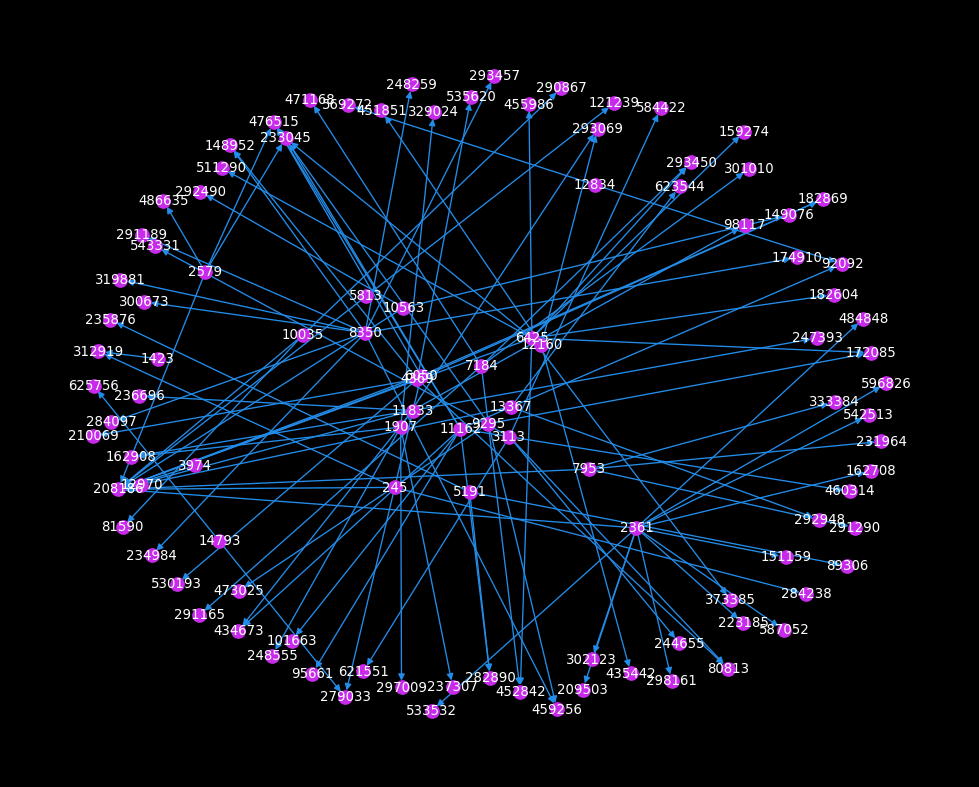

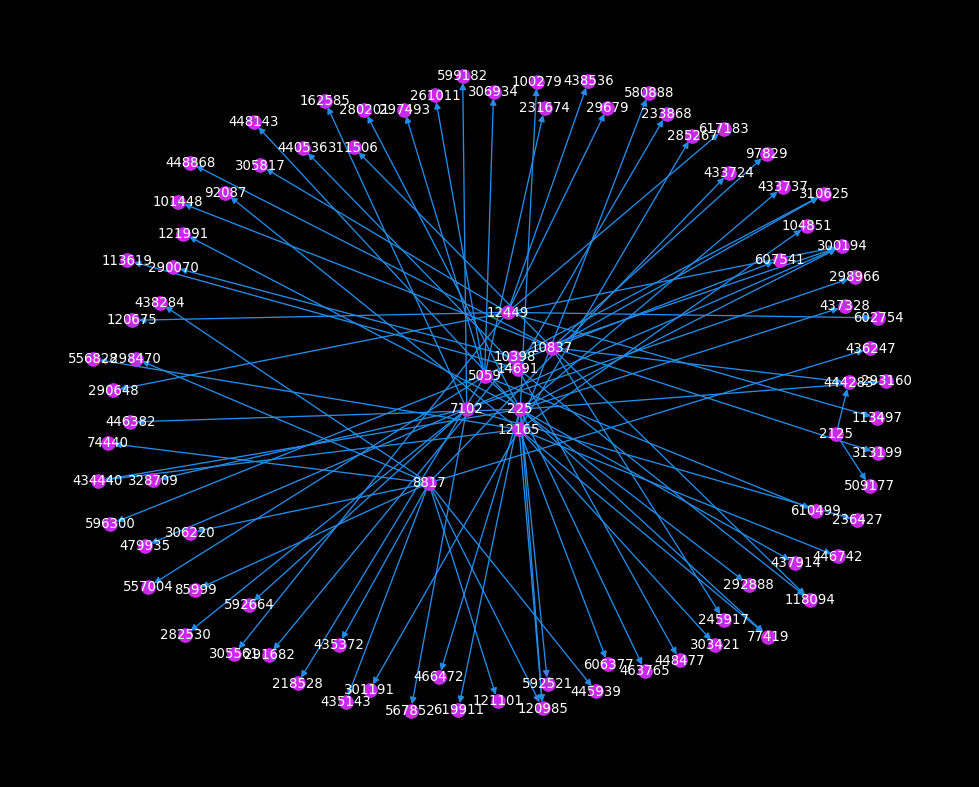

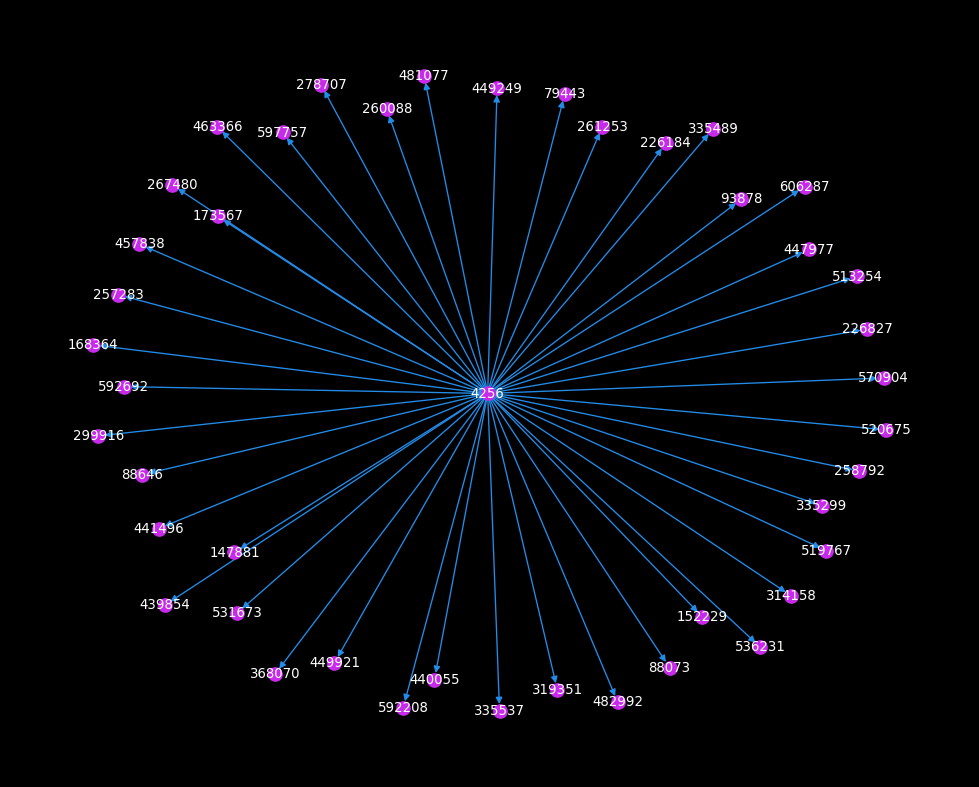

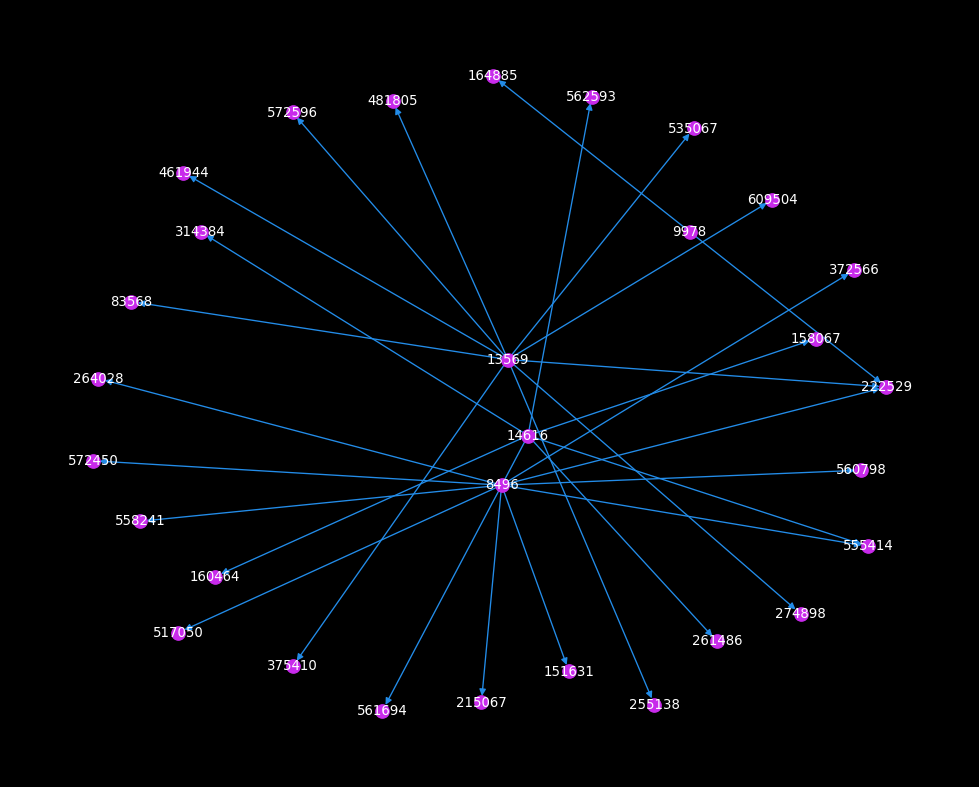

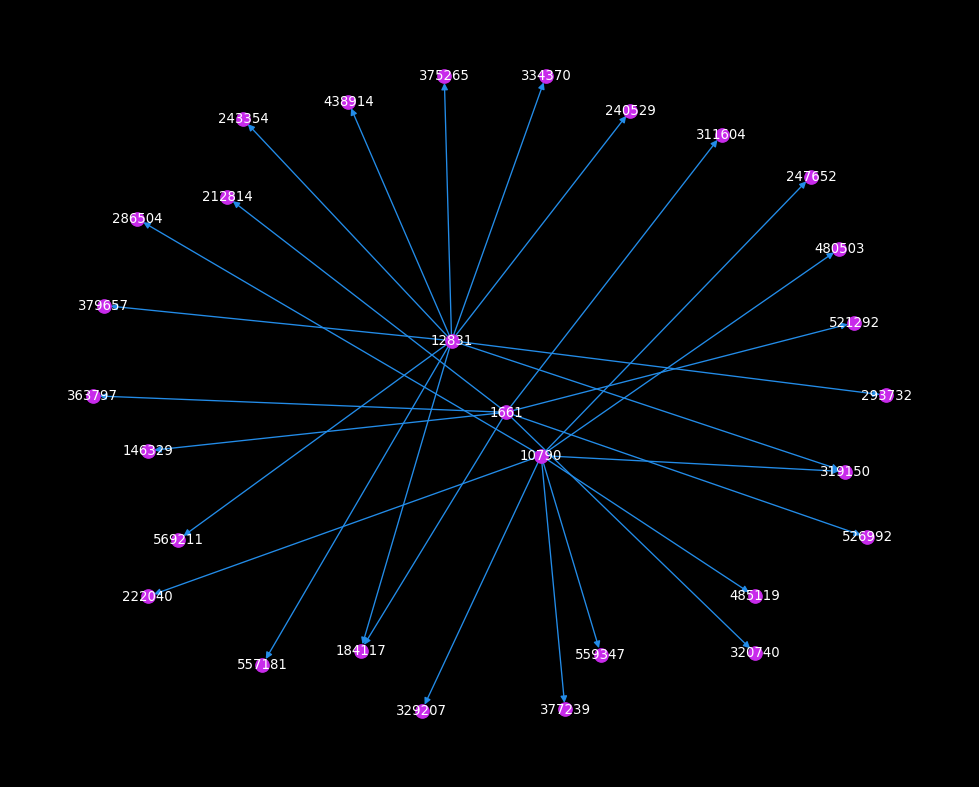

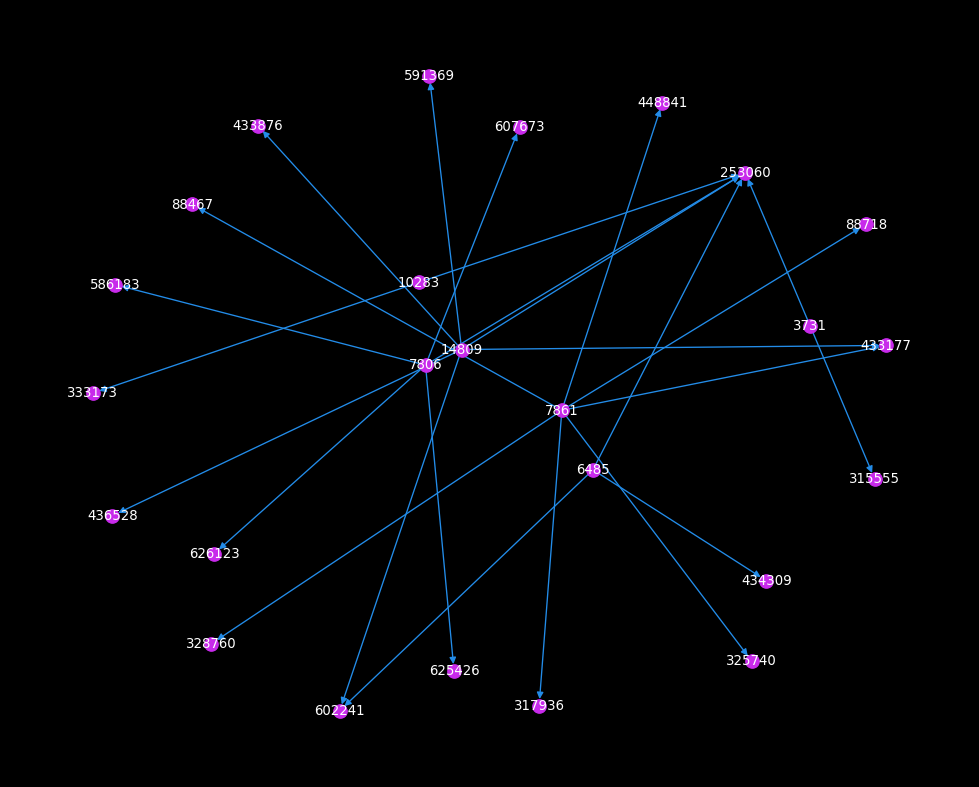

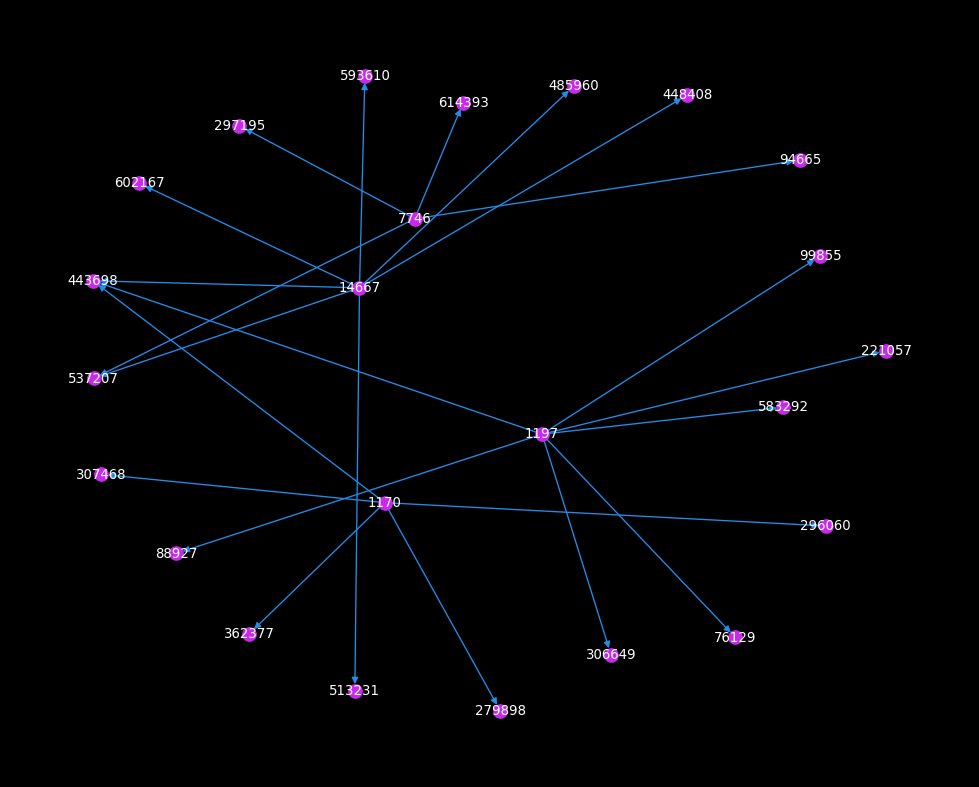

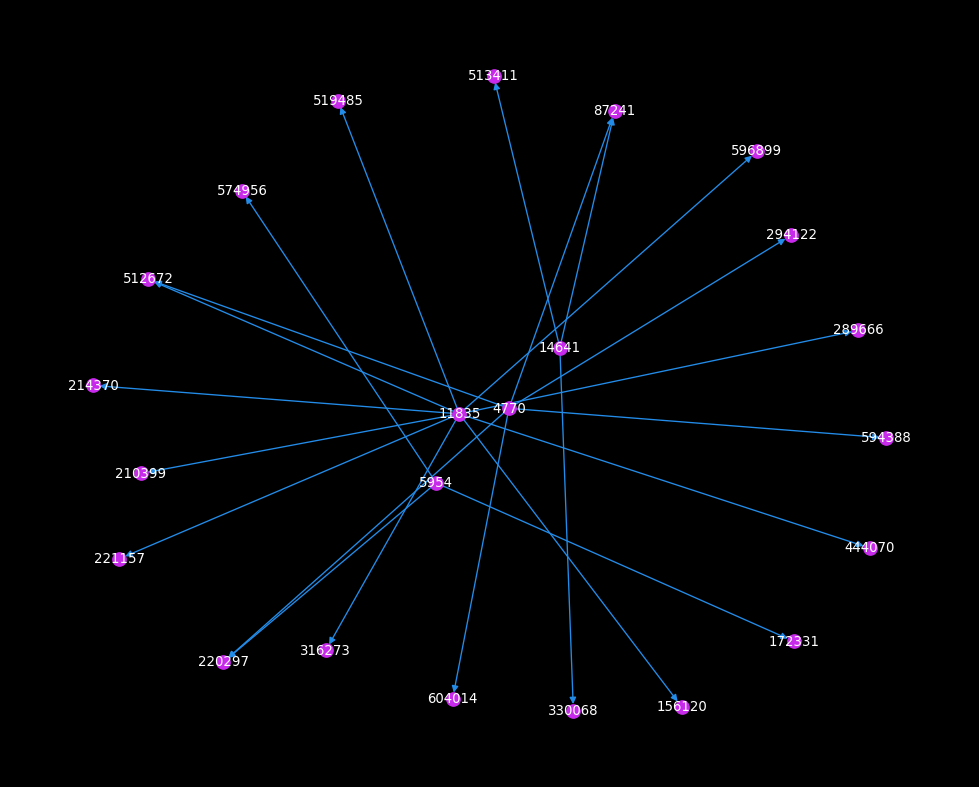

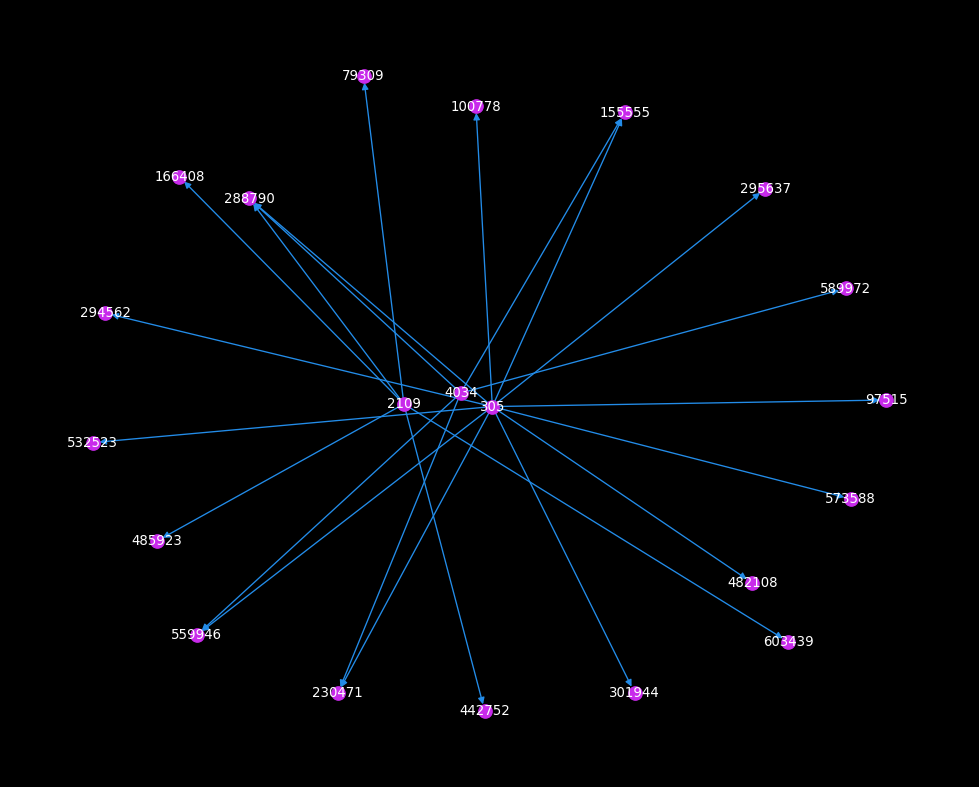

In [19]:
# Find weakly connected components
comps = list(nx.weakly_connected_components(G))

# Get 10 largest weakly connected component
comps.sort(key=lambda t: len(t), reverse=True)
for comp in comps[:10]:
    fig = plt.figure(figsize=(10,8), dpi=96)
    nx.draw_spring(
        G.subgraph(comp),
        with_labels=True,
        node_color=NODE_COLOR,
        node_size=100,
        edge_color=EDGE_COLOR,
        font_size=10,
        font_color=FONT_COLOR
    )
    fig.set_facecolor('k')

### Plot the original graph and color the nodes based on clusters

In [20]:
# Create a map that assigns a value to each node
node_value_map = {}
for idx, comp in enumerate(comps):
    for node in comp:
        node_value_map[node] = idx
        
node_values = [node_value_map[n] for n in G.nodes()]

In [21]:
# Plot the original with different colors for each connected subgraph
if DRAW_FULL_GRAPHS:
    cmap = plt.get_cmap('rainbow')
    fig = plt.figure(figsize=(8,6), dpi=96)
    nx.draw(
        G,
        cmap=cmap,
        node_color=node_values,
        node_size=100,
        with_labels=True, 
        edge_color=EDGE_COLOR,
        font_size=9, 
        font_color=FONT_COLOR
    )
    fig.set_facecolor('k')

In [22]:
# Build a refernece list for each year
node_list_yearly = {}
edge_list_yearly = {}
for node in nodelist:
    year = node.data[TAG_YEAR]
    if not year in node_list_yearly.keys():
        node_list_yearly[year] = set([hash(node)])
    else:
        node_list_yearly[year].add(hash(node))
    
    if node.data[TAG_REF] != []:
        for ref in node.data[TAG_REF]:
            # Search for the respective node
            refnode = [x for x in nodelist if x.data[TAG_IDX] == ref]
            if refnode != []:
                refyear = refnode[0].data[TAG_YEAR]
                if not refyear in edge_list_yearly.keys():
                    edge_list_yearly[refyear] = set([(ref, hash(node))])
                else:
                    edge_list_yearly[refyear].add((ref, hash(node)))

In [38]:
yearlystats = {}
for year in np.arange( max(min(list(node_list_yearly.keys())), min(list(edge_list_yearly.keys()))),
                       max(max(list(node_list_yearly.keys())), max(list(edge_list_yearly.keys()))) ):
    H = nx.DiGraph()
    for k in node_list_yearly.keys():
        if k<year:
            [H.add_node(n) for n in node_list_yearly[k]]
    for k in edge_list_yearly.keys():
        if k<year:
            [H.add_edge(*e) for e in edge_list_yearly[k]]
    
    stats = {}
    stats['num_of_new_nodes'] = len(node_list_yearly[year]) if year in node_list_yearly else 0
    stats['num_of_new_edges'] = len(edge_list_yearly[year]) if year in edge_list_yearly else 0
    in_degree_sequence = sorted([d for n, d in H.in_degree()], reverse=True)
    stats['in_degree_seq'] = in_degree_sequence
    out_degree_sequence = sorted([d for n, d in H.out_degree()], reverse=True)
    stats['out_degree_seq'] = out_degree_sequence
    stats['average_clustering'] = nx.algorithms.cluster.average_clustering(H)
    stats['number_of_isolates'] = nx.algorithms.isolate.number_of_isolates(H)
    yearlystats[year]=stats

<ErrorbarContainer object of 3 artists>

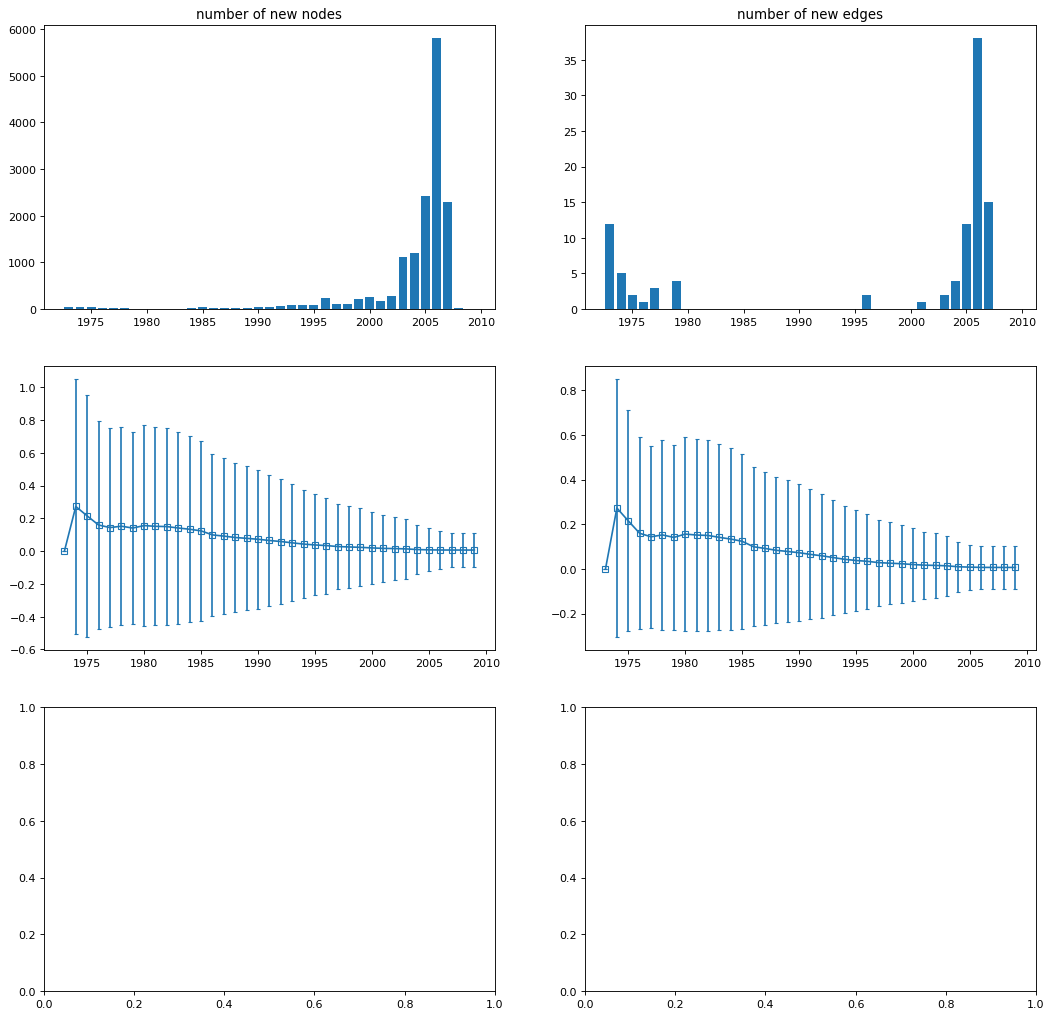

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), dpi=80)

t = list(yearlystats.keys())
axes[0][0].bar(
    t,
    [yearlystats[yr]['num_of_new_nodes'] for yr in t],
    width=0.8
)
axes[0][0].set_title('number of new nodes')
axes[0][1].bar(
    t,
    [yearlystats[yr]['num_of_new_edges'] for yr in t],
    width=0.8
)
axes[0][1].set_title('number of new edges')

axes[1][0].errorbar(
    x=t,
    y=[np.mean(yearlystats[yr]['in_degree_seq']) for yr in t],
    yerr=[np.std(yearlystats[yr]['in_degree_seq']) for yr in t],
    capsize=2,
    marker='s',
    fillstyle='none'
)
axes[1][1].errorbar(
    x=t,
    y=[np.mean(yearlystats[yr]['out_degree_seq']) for yr in t],
    yerr=[np.std(yearlystats[yr]['out_degree_seq']) for yr in t],
    capsize=2,
    marker='s',
    fillstyle='none'
)

In [ ]:
# Iteratively build up the full graph year by year.
from itertools import groupby

"""
 - Sort nodes by year
 - Create groups of nodes based on year
"""
nodelist_sorted = {}
nodelist.sort(key=lambda n: n.data[TAG_YEAR])

for key, valuesiter in groupby(nodelist, key=lambda n: n.data[TAG_YEAR]):
    nodelist_sorted[key] = list(v for v in valuesiter)
    
"""
 Iteratively add each year to the graph
"""
graph_nodes_cumulative = {}
year_prev=None
for year in nodelist_sorted.keys():
    if year_prev==None:
        graph_nodes_cumulative[year]=set(map(lambda n: hash(n), nodelist_sorted[year]))
    else:
        graph_nodes_cumulative[year]=graph_nodes_cumulative[year_prev].union(set(map(lambda n: hash(n), nodelist_sorted[year])))
    year_prev=year

In [ ]:
yearlydata = {}
for year in nodelist_sorted.keys():
    H = G.subgraph(graph_nodes_cumulative[year])
    stats = {}
    in_degree_sequence = sorted([d for n, d in H.in_degree()], reverse=True)
    stats['in_degree_seq'] = in_degree_sequence
    out_degree_sequence = sorted([d for n, d in H.out_degree()], reverse=True)
    stats['out_degree_seq'] = out_degree_sequence
    stats['average_clustering'] = nx.algorithms.cluster.average_clustering(H)
    stats['number_of_isolates'] = nx.algorithms.isolate.number_of_isolates(H)
    yearlydata[year]=stats
    plt.figure()
    nx.draw(H)
    #print(np.max(out_degree_sequence))

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16), dpi=80)

t = list(yearlydata.keys())
axes[0][0].errorbar(
    x=t,
    y=[np.mean(yearlydata[yr]['in_degree_seq']) for yr in t],
    yerr=[np.std(yearlydata[yr]['in_degree_seq']) for yr in t],
    capsize=2,
    marker='s',
    fillstyle='none'
)
axes[0][1].errorbar(
    x=t,
    y=[np.mean(yearlydata[yr]['out_degree_seq']) for yr in t],
    yerr=[np.std(yearlydata[yr]['out_degree_seq']) for yr in t],
    capsize=2,
    marker='s',
    fillstyle='none'
)

In [ ]:
nx.draw(G.subgraph(comps[6]))

In [ ]:
nx.draw(G.subgraph(comps[7]))

In [ ]:
nx.draw(G.subgraph(comps[6].union(comps[7])))

In [ ]:
node_list_yearly

In [ ]:
edge_list_yearly